What is changed from the last notebook?
- Added some personal constraints
- Lunch from 12:30 to 1pm

Assumptions:
- Even though Analytics Lab has a smaller number of units (9 in comparison to 12 for ML, Opt, and Edge), it is very project-oriented which is why we assume that it requires the same amount of time for project meetings
- Study time (homeworks, individual project work, study lecture material) for each subject was estimated based on MIT Registrar's Office (lecture - office hours - project)

ML: 3-1-8 -> Estimation study time: homeworks (5) + individual project work (8-2=6) + study lecture material (3)

Opt: 4-0-8 -> Estimation study time:  homeworks (5) + individual project work (8-2=6) + study lecture material (3)

A-Lab: 2-0-7 -> Estimation study time: homeworks (0) + individual project work (7-2=5) + study lecture material (0)

Edge: 4-0-8 -> Estimation study time: homeworks (3) + individual project work (8-2=6) + study lecture material (2)

SUM of all hours: 44


In [67]:
using JuMP, Gurobi, CSV, Tables

In [68]:
Students_raw = CSV.File("../Data/Name_dict.csv", header=false) |> Tables.matrix;
ALab_raw = CSV.File("../Data/Teams_ALab.csv", header=false) |> Tables.matrix;
Edge_raw = CSV.File("../Data/Teams_Edge.csv", header=false) |> Tables.matrix;
ML_raw = CSV.File("../Data/Teams_ML.csv", header=false) |> Tables.matrix;
Opt_raw = CSV.File("../Data/Teams_Opt.csv", header=false) |> Tables.matrix;
RA_students = [1,2,4,5,6,8,10,12,15,20,36,41,46];

#Personalized constraints
Leadership_students = [2, 12,21, 24, 30,31,34,44];
Sloan_senate = [2, 26];
Football_match = [23, 29];
Catholic_mass = [1];

In [69]:
Students = hcat(parse.(Float64, Students_raw[2:end,1]),Students_raw[2:end,2])
ALab = parse.(Int64, ALab_raw[2:end,:]);
Edge = parse.(Int64, Edge_raw[2:end,:]);
ML = parse.(Int64, ML_raw[2:end,:]);
Opt = parse.(Int64, Opt_raw[2:end,:]);

In [70]:
function get_groups(mat)
    n = size(mat, 1)
    new_mat = []
    for i in 1:n
        inds = findall(x->x!=99, mat[i,:])
        push!(new_mat, Int.(mat[i,inds]))
    end
    return new_mat
end

get_groups (generic function with 1 method)

In [61]:
ALab = get_groups(ALab);
Edge = get_groups(Edge);
ML = get_groups(ML);
Opt = get_groups(Opt);

In [62]:
env = Gurobi.Env();

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-19


**Activities**: {  
    1 := sleep,  
    2 := free time,  
    3 := class,  
    4 := ALab meeting,  
    5 := Edge meeting,  
    6 := ML meeting,  
    7 := Opt meeting,  
    8 := RA work,  
    9 := eat,  
    10 := study,  
    11 := personal
}

In [63]:
```
A := activities
S := students
C := class time periods 
```
function freetime_model(A, S, C, ALab, Edge, ML, Opt)
    
    model = Model(() -> Gurobi.Optimizer(env)) ;
    set_time_limit_sec(model, 20)
    set_optimizer_attribute(model, "OutputFlag", 1)
    set_optimizer_attribute(model, "MIPGap", 5e-3)
    
    n_A = length(A)
    n_S = size(S, 1)
    n_al = length(ALab)
    n_ed = length(Edge)
    n_ml = length(ML)
    n_opt = length(Opt)
    
    #initializing weights for free time as 1 (at the end we will value free time durng 9am-5pm from Monday to Friday as 1 - baseline)
    free_time_weights = ones(Float16, (size(Students, 1),7,48))
    
    #free time during: 
    #8am-9am from Monday to Friday | 5-11pm from Monday to Thursday | 11am-5pm from Saturday | 11am-11pm Sunday
    #is consdered 3 times more valuable
    for s in 1:size(Students, 1)
        for d in 1:5
            free_time_weights[CartesianIndex.(s,d,17:18)] .= 3
        end
        for d in 1:4
            free_time_weights[CartesianIndex.(s,d,35:46)] .= 3
        end
        free_time_weights[CartesianIndex.(s,6,23:34)] .= 3
        free_time_weights[CartesianIndex.(s,7,23:46)] .= 3
    end
    
    #free time during: 
    #5pm -  midnight on Friday | midnight-1am & 5pm - midnight Saturday | midnight-1am Sunday
    #is consdered 5 times more valuable
    for s in 1:size(Students, 1)
        for d in 5:6
            free_time_weights[CartesianIndex.(s,d,35:48)] .= 5
        end
        for d in 6:7
            free_time_weights[CartesianIndex.(s,d,1:2)] .= 5            
        end
    end
    
    # variable for student activities over time
    @variable(model, x[1:n_S, 1:n_A, 1:7, 1:48], Bin)
    
    # variable for indicating if the group is all doing the correct meeting
    @variable(model, al[1:n_al, 1:7, 1:45], Bin)
    @variable(model, ed[1:n_ed, 1:7, 1:45], Bin)
    @variable(model, ml[1:n_ml, 1:7, 1:45], Bin)
    @variable(model, opt[1:n_opt, 1:7, 1:45], Bin)
    
    # Must do one activity at a time
#     @constraint(model, [s=1:n_S], sum(x[s,:,:,:], dims=1) .== 1)
    @constraint(model, [s=1:n_S, d=1:7, t=1:48], x[s,:,d,t] in SOS1())
    
    # at the moment, we allocating time for sleep between 11pm and 7am (8hrs) during weekdays
    @constraint(model, [s=1:n_S, d=1:4], x[s,1,d,vcat(1:14,end-1:end)].==1)
    #on Friday, time allocated for sleep in only until 7am
    @constraint(model, [s=1:n_S], x[s,1,5,vcat(1:14)].==1)
    #on Saturday, time allocated for sleep is from 1 am to 10 am 
    @constraint(model, [s=1:n_S], x[s,1,6,vcat(3:20)].==1)
    #on Saturday, time allocated for sleep is from 1 am to 10 am and from 11pm 
    @constraint(model, [s=1:n_S], x[s,1,7,vcat(3:20,end-1:end)].==1)
    
    # at the moment, we are forcing students to attend classes
    for day in 1:7
        @constraint(model, [s=1:n_S], x[s,3,day,C[day]].==1)
    end
    
    # ALab
    @constraint(model, sum(al, dims=(2,3)) .>= 1)
    for (i, group) in enumerate(ALab)
        @constraint(model, [d=1:7, t=1:45, s in group, t1=t:t+3], al[i,d,t] <= x[s, 4, d, t1])
    end
    
    # Edge
    @constraint(model, sum(ed, dims=(2,3)) .>= 1)
    for (i, group) in enumerate(Edge)
        @constraint(model, [d=1:7, t=1:45, s in group, t1=t:t+3], ed[i,d,t] <= x[s, 5, d, t1])
    end
    
    # ML
    @constraint(model, sum(ml, dims=(2,3)) .>= 1)
    for (i, group) in enumerate(ML)
        @constraint(model, [d=1:7, t=1:45, s in group, t1=t:t+3], ml[i,d,t] <= x[s, 6, d, t1])
    end
    
    # Opt
    @constraint(model, sum(opt, dims=(2,3)) .>= 1)
    for (i, group) in enumerate(Opt)
        @constraint(model, [d=1:7, t=1:45, s in group, t1=t:t+3], opt[i,d,t] <= x[s, 7, d, t1])
    end
    
    # students who are doing RA need to work on research for at least 10h per week
    @constraint(model, [s=RA_students], sum(sum(x[s,8,:,:])).>=10)
    
    # at the moment, we allocating time for eating during weekdays as follows: 
    #breakfast 7am-8am (including morning bathroom), lunch 12:30pm-1pm, dinner (we leave it as a decision to students)
    @constraint(model, [s=1:n_S, d=1:5], x[s,9,d,vcat(15:16, 26)].==1)
    #on Saturday and on Saturday, time allocated for eating is as follows:
    #breakfast 10am-11am (including morning bathroom), lunch 3pm-4pm, dinner (we leave it as a decision to students)
    @constraint(model, [s=1:n_S, d=6:7], x[s,9,d,vcat(21:22, 31:32)].==1)
    
    #students need to study (homeworks, individual project work, study lecture material) for at least 44h per week (estimated based on MIT Registrar's Office)
    @constraint(model, [s=1:n_S], sum(sum(x[s,10,:,:])).>=44)
    
    #### Personal 
    #MBAn Leadership Student Council
    @constraint(model, [s=Leadership_students], x[s,11,4,vcat(24:25)].==1)
    
    #Sloan senate
    @constraint(model, [s=Sloan_senate], x[s,11,2,vcat(24:25)].==1)
    
    #MIT Sloan Football matches
    @constraint(model, [s=Football_match], x[s,11,7,vcat(33:34, 39:42)].==1)
    @constraint(model, [s=Football_match, d=[1,3]], x[s,11,d,vcat(43:46)].==1)

    #Catholic mass 
    @constraint(model, [s=Catholic_mass], x[s,11,7,vcat(27:28)].==1)
    
    # objective is maximixing free time for now
    @objective(model, Max, sum(free_time_weights.*x[:,2,:,:]))
    
    optimize!(model)
 
    return value.(x), value.(al), value.(ed), value.(ml), value.(opt), model
end

freetime_model (generic function with 1 method)

In [64]:
Monday = vcat(27:29, 33:35)
Tuesday = vcat(18:20)
Wednesday = vcat(27:29, 33:35)
Thursday = vcat(18:20, 30:38)
Friday = vcat(19:20, 22:23, 29:30)
Saturday = []
Sunday = []
Classes = [Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday]

7-element Vector{Vector{Any}}:
 [27, 28, 29, 33, 34, 35]
 [18, 19, 20]
 [27, 28, 29, 33, 34, 35]
 [18, 19, 20, 30, 31, 32, 33, 34, 35, 36, 37, 38]
 [19, 20, 22, 23, 29, 30]
 []
 []

In [65]:
@time x, al, ed, ml, opt, m = freetime_model([1,2,3,4,5,6,7,8,9,10,11], Students, Classes, ALab, Edge, ML, Opt);

Set parameter TimeLimit to value 20
Set parameter MIPGap to value 0.005
Set parameter MIPGap to value 0.005
Set parameter TimeLimit to value 20
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 247701 rows, 207417 columns and 540799 nonzeros
Model fingerprint: 0x66f9ea48
Model has 15792 SOS constraints
Variable types: 0 continuous, 207417 integer (207417 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 5e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+01]
Presolve removed 169164 rows and 166279 columns
Presolve time: 2.78s
Presolved: 78537 rows, 41138 columns, 197980 nonzeros
Variable types: 0 continuous, 41138 integer (41036 binary)
Found heuristic solution: objective 16806.000000

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing first log only...

Root relaxation preso

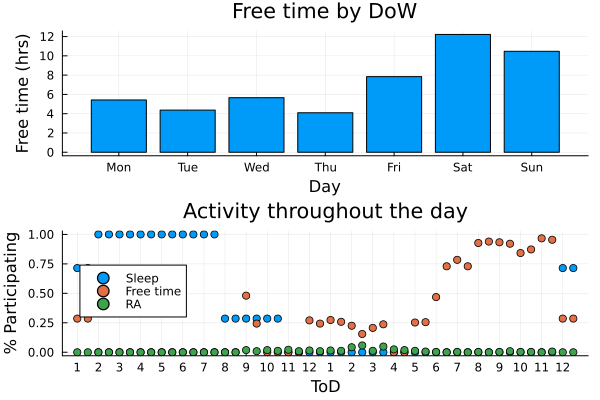

In [71]:
tod=[1,2,3,4,5,6,7,8,9,10,11,12,1,2,3,4,5,6,7,8,9,10,11,12]
ft_by_day = reshape(sum(x[:,2,:,:], dims=(1,3)),7)/size(x,1)/2
ft_by_time = reshape(sum(x[:,2,:,:], dims=(1,2)),48)/size(x,1)/7
slp_by_time = reshape(sum(x[:,1,:,:], dims=(1,2)),48)/size(x,1)/7
ra_by_time = reshape(sum(x[:,8,:,:], dims=(1,2)),48)/size(x,1)/7
p_day = bar(1:7, ft_by_day, title="Free time by DoW", xlabel="Day", ylabel="Free time (hrs)",legend=false)
plot!(xticks=(1:7, ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]))
p_time = scatter(1:48, slp_by_time, labels="Sleep", title="Activity throughout the day", xlabel="ToD", ylabel="% Participating")
scatter!(1:48, ft_by_time, labels="Free time")
scatter!(1:48, ra_by_time, labels="RA")
plot!(xticks=(1:2:48, tod),legend=:left)
# scatter([1],[0.5])
plot(p_day, p_time, layout=(2,1))

In [72]:
free_time_weights = ones(Float16, (size(Students, 1),7,48))
    
#free time during weekends is considered 5 times more valuable
for s in 1:size(Students, 1)
    for d in 6:7
        free_time_weights[CartesianIndex.(s,d,1:48)] .= 5
    end
end

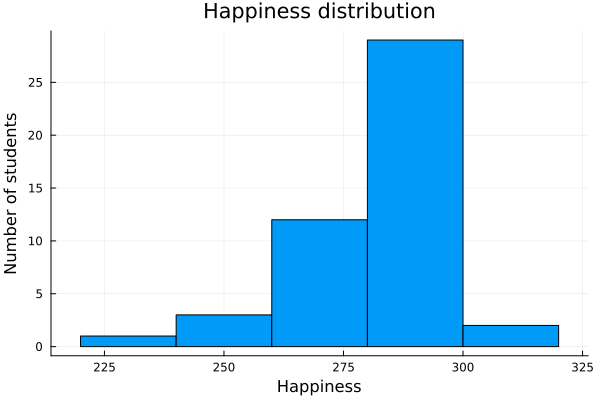

In [74]:
happy = reshape(sum(free_time_weights.*x[:,2,:,:],dims=(2,3)),size(Students,1));
histogram(happy, title="Happiness distribution", xlabel="Happiness", ylabel="Number of students",legend=false)

In [81]:
a_names = ["Sleep", "Free time", "Classes", "ALab", "Edge", "ML", "Opt", "RA", "Eating", "Study", "Other"]
days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
shapes = [:star7, :circle, :cross, :diamond, :dtriangle, :pentagon, :octagon, :pentagon, :rect, :x, :rtriangle, :utriangle, :x, :xcross]
t = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47]
plts = []
for day in 1:7    
    plt = plot(title=days[day], xlabel="ToD", ylabel="MBAn", yticks=([1/4,1/2,3/4,1], ["Michal", "Tom", "Victor", "Marco"]), legend=:best)
    plot!(ylim=(0.1,1.1))
    plot!(xticks=(1:2:48, tod),legend=:left)
    for (i, s) in enumerate([1,2,21,23])
        for a in [1,2,3,4,5,6,7,8,9,10,11]
            by_time = x[s,a,day,:]*(i/4)
            inds = findall(x -> x > 0, by_time)
            if i == 1
                plt = scatter!(t[inds], by_time[inds], labels=a_names[a], color=a, shape=shapes[a])
            else
                plt = scatter!(t[inds], by_time[inds], labels="", color=a , shape=shapes[a])
            end
        end
    end
    push!(plts, plt)
end 

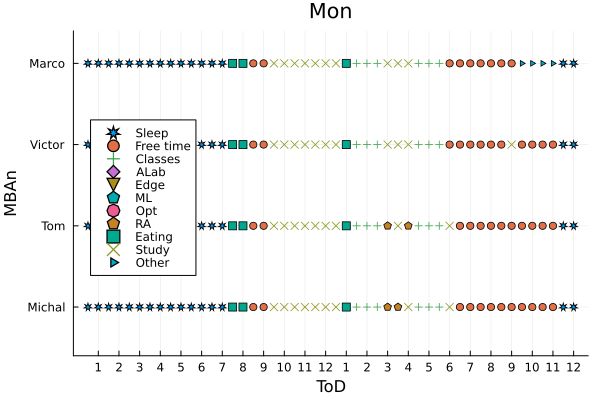

In [82]:
plts[1]

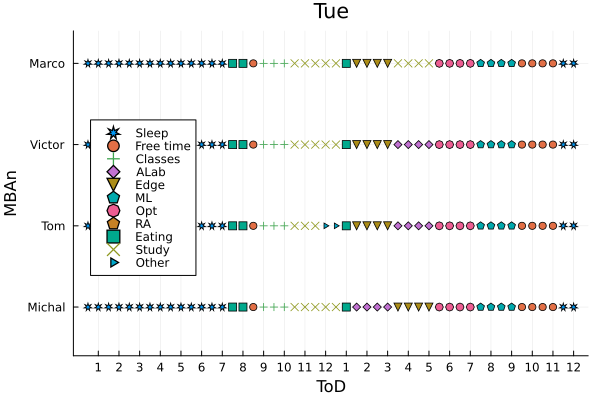

In [83]:
plts[2]

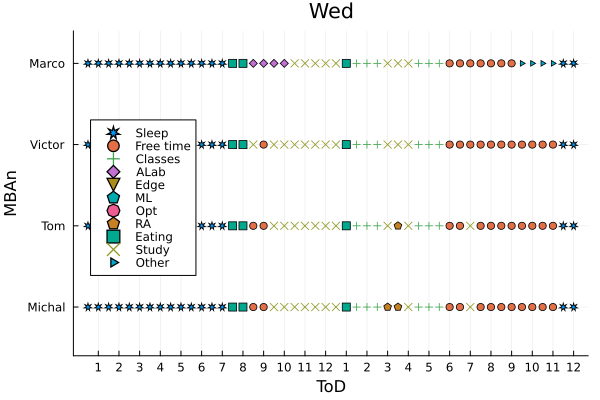

In [84]:
plts[3]

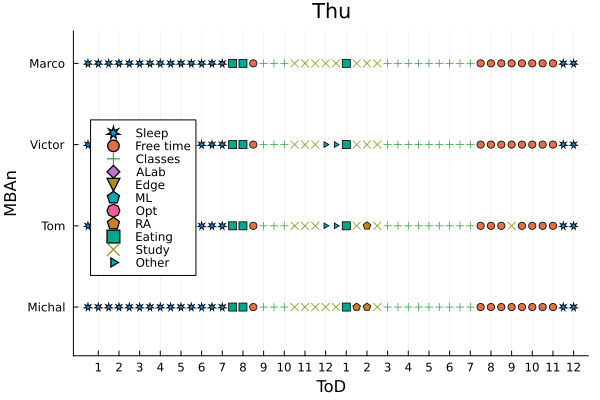

In [85]:
plts[4]

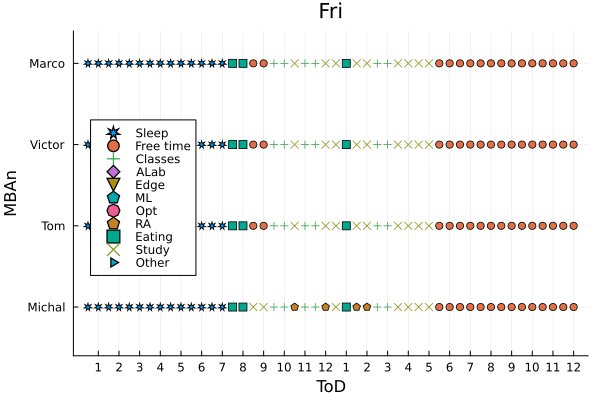

In [86]:
plts[5]

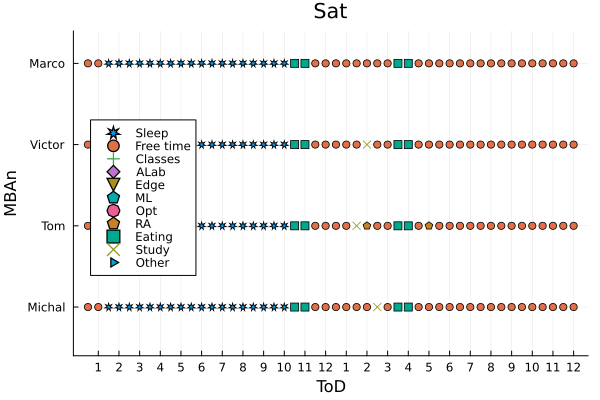

In [87]:
plts[6]

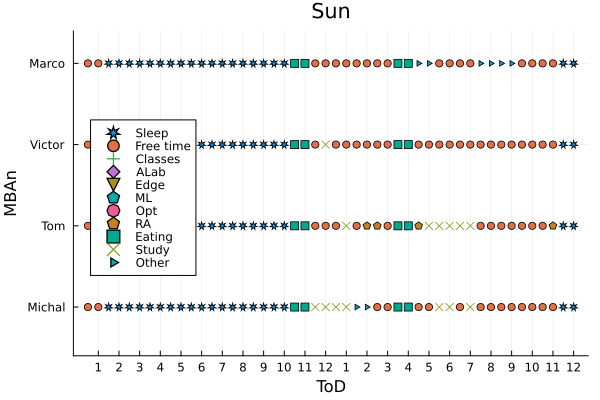

In [88]:
plts[7]